In [1]:
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

from nilearn.maskers import NiftiMasker
from nilearn.masking import compute_brain_mask
from nilearn.plotting import plot_stat_map, show
from nilearn.plotting import plot_roi, plot_glass_brain
from nilearn.image import clean_img
from nilearn.decoding import SpaceNetClassifier

# Loading the Data

In [3]:
# load beta images
# And clean them, replacing nans by 0s ...
beta_maps_dir = 'data/beta_maps'
beta_maps = []
for file in sorted(os.listdir(beta_maps_dir)):
    if file.endswith('.nii.gz'):
        map = nib.load(os.path.join(beta_maps_dir, file))
        beta_maps.append(clean_img(map, standardize=False, ensure_finite=True))

nb_sub = len(beta_maps)

print('Number of subjects: ', nb_sub)

Number of subjects:  49


# Obtaining the Mask

Shape of the mask:  (91, 109, 91)


C:\Users\User\miniforge3\lib\site-packages\nilearn\plotting\img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


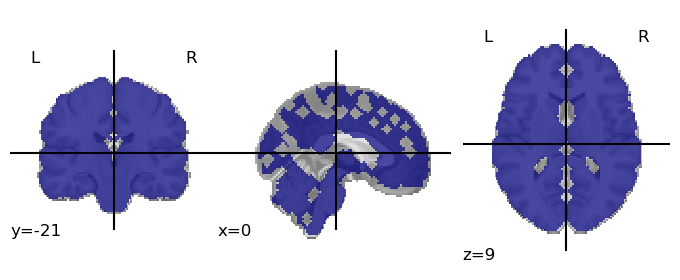

In [4]:
anat_path = 'data/anatomy/mask.nii'
anatomy = nib.load(anat_path)
mask = compute_brain_mask(anatomy)

print('Shape of the mask: ', mask.shape)
plot_roi(mask)

# Labels

In [5]:
random.seed(42)
labels = np.tile(['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit'], 5*49)
print('Numbers of labels/training samples: ', len(labels))

Numbers of labels/training samples:  1470


# Splitting the Test Data

In [6]:
num_subs_for_test = 4
num_imgs_per_sub = 30
beta_maps_test = nib.funcs.concat_images(beta_maps[:num_subs_for_test], axis = -1)
labels_test = labels[:num_imgs_per_sub * num_subs_for_test]

# Splitting the Train Data for CV

In [7]:
labels_train = labels[num_imgs_per_sub * num_subs_for_test:]

beta_maps_train_9sub = nib.funcs.concat_images(beta_maps[num_subs_for_test:], axis = -1)

beta_maps_train_run = beta_maps[num_subs_for_test].slicer[..., :6]

for i in range(5):
    for j in range(45):
        sliced_by_run = beta_maps[j+num_subs_for_test].slicer[..., (i*6):(i*6 + 6)]
        beta_maps_train_run = nib.funcs.concat_images([beta_maps_train_run, sliced_by_run], axis = -1)

beta_maps_train_run = beta_maps_train_run.slicer[..., 6:]

# SpaceNet Classifier - 5fold CV per 9 subjects

In [10]:
# This is the run for 5fold CV per 9 subjects!
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=mask,
                             max_iter=10, # default is 200
                             cv=5,
                             n_jobs=1,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

decoder.fit(beta_maps_train_9sub, labels_train)

print(getattr(decoder,'cv_'))
print(getattr(decoder,'cv_scores_'))
print(getattr(decoder,'best_model_params_'))

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


Time Elapsed: 118.017 seconds, 1 minutes.
[(array([ 270,  271,  272, ..., 1347, 1348, 1349]), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 

In [11]:
# Prediction
test_pred = decoder.predict(beta_maps_test)
# Return average accuracy
accuracy = (test_pred == labels_test).mean() * 100.
print("\nSpaceNet Classifier (5fold CV per 9 subjects) test accuracy : %g%%" % accuracy)


SpaceNet Classifier (5fold CV per 9 subjects) test accuracy : 71.6667%


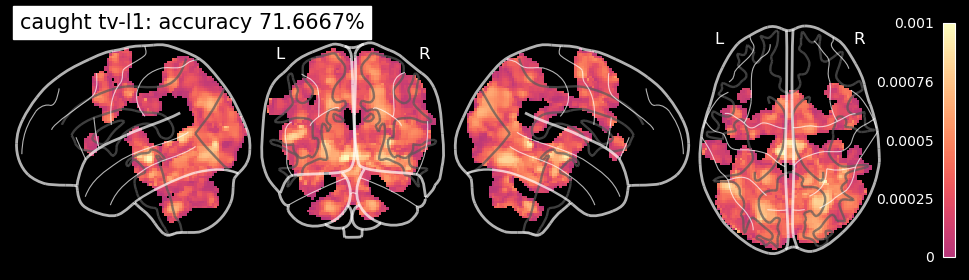

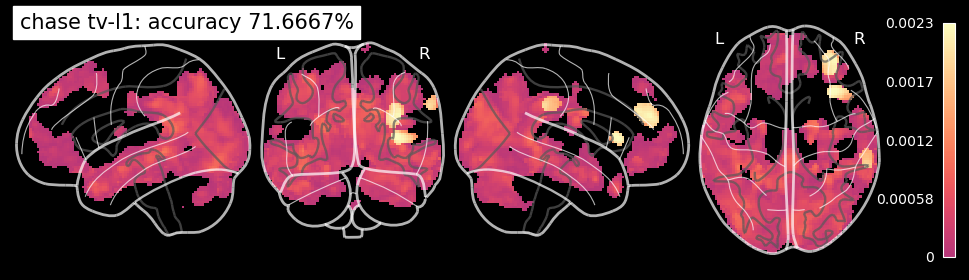

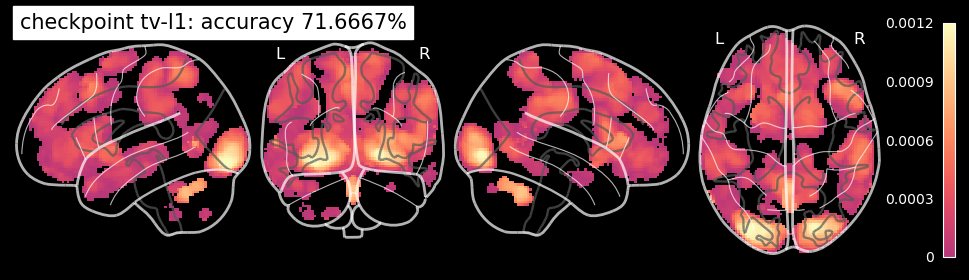

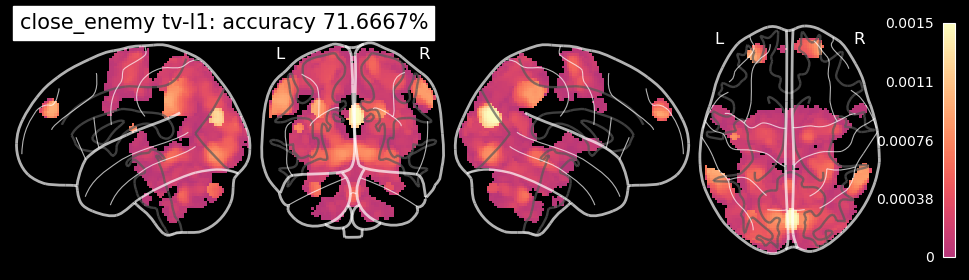

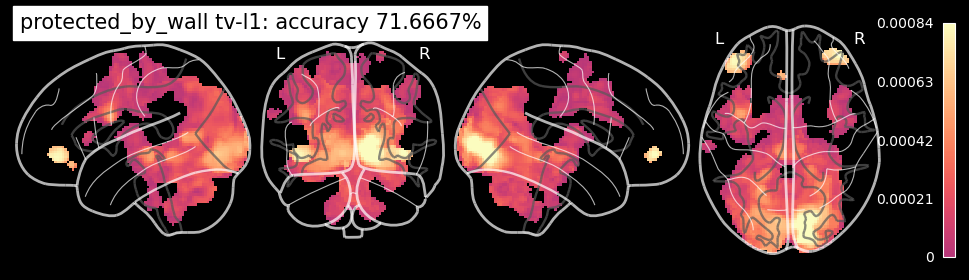

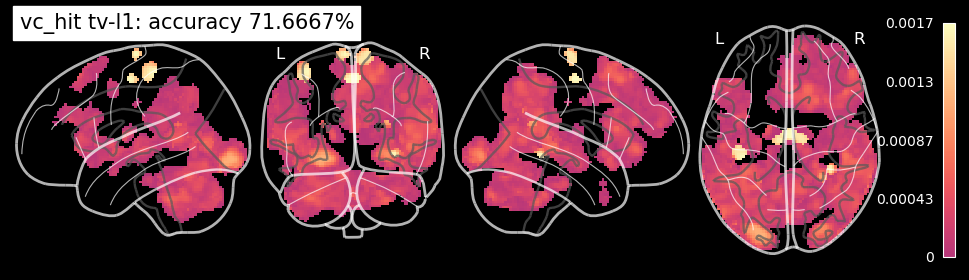

In [12]:
coef_img = decoder.coef_img_

conditions = ['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit']
for i, condition in enumerate(conditions):
    plot_glass_brain(coef_img.slicer[...,i], black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title=condition + ' tv-l1: accuracy %g%%' % accuracy)

# SpaceNet Classifier - 5fold CV per run

In [13]:
# This is the run for 5fold CV per run!
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=mask,
                             max_iter=10, # default is 200
                             cv=5,
                             n_jobs=1,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

decoder.fit(beta_maps_train_run, labels_train)

print(getattr(decoder,'cv_'))
print(getattr(decoder,'cv_scores_'))
print(getattr(decoder,'best_model_params_'))

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(91, 109, 91, 1350),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


C:\Users\User\miniforge3\lib\site-packages\nilearn\maskers\nifti_masker.py:570: UserWarning: Persisting input arguments took 12.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.25s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


_____________________________________________________path_scores - 88.2s, 1.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.92s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 75.8s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.95s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 75.5s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.94s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 78.0s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.94s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 76.4s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 80.1s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 84.3s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.11s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 78.7s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 80.8s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.92s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 79.0s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 78.5s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 83.9s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.97s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 81.4s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 83.3s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.92s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 82.3s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 81.4s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.95s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 80.1s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 78.8s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 85.4s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.20s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


____________________________________________________path_scores - 100.3s, 1.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.22s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 96.2s, 1.6min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.11s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 92.6s, 1.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 95.5s, 1.6min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.16s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 92.5s, 1.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.13s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 92.2s, 1.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.09s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


____________________________________________________path_scores - 100.2s, 1.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.93s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


____________________________________________________path_scores - 115.5s, 1.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 4.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


____________________________________________________path_scores - 111.2s, 1.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 4.09s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


____________________________________________________path_scores - 103.9s, 1.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000026F18D7E4D0>, loss='logistic'), array([[0.000000e+00, ..., 1.673241e-09],
       ...,
       [0.000000e+00, ..., 1.673241e-09]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 4.39s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 47.2min finished


____________________________________________________path_scores - 113.4s, 1.9min
Time Elapsed: 2881.56 seconds, 48 minutes.
[(array([ 270,  271,  272, ..., 1347, 1348, 1349]), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 

In [14]:
# Prediction
test_pred = decoder.predict(beta_maps_test)
# Return average accuracy
accuracy = (test_pred == labels_test).mean() * 100.
print("\nSpaceNet Classifier (5fold CV per run) test accuracy : %g%%" % accuracy)


SpaceNet Classifier (5fold CV per run) test accuracy : 70%


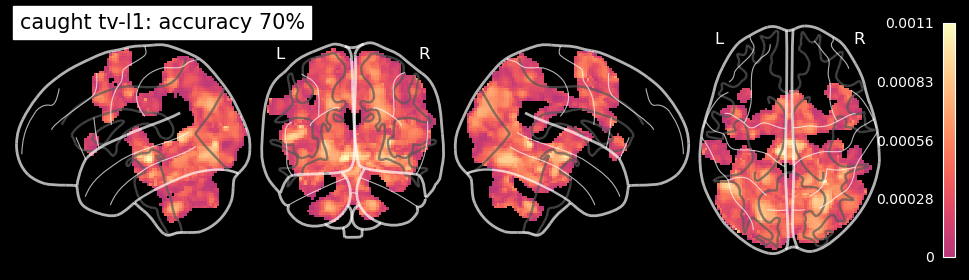

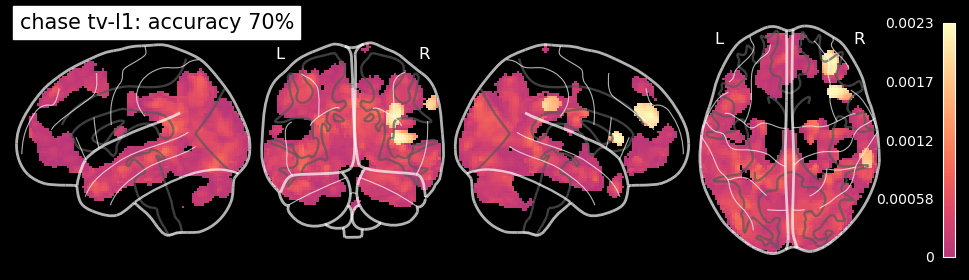

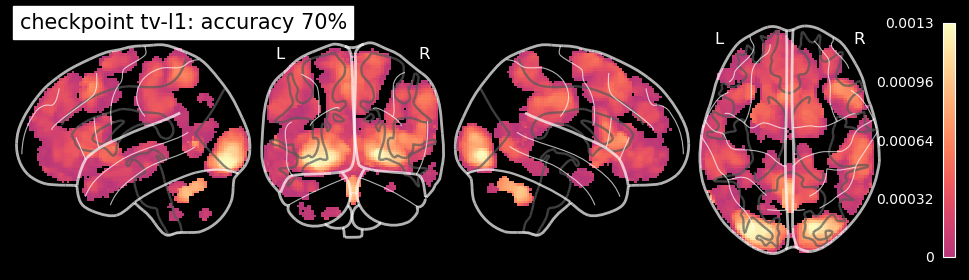

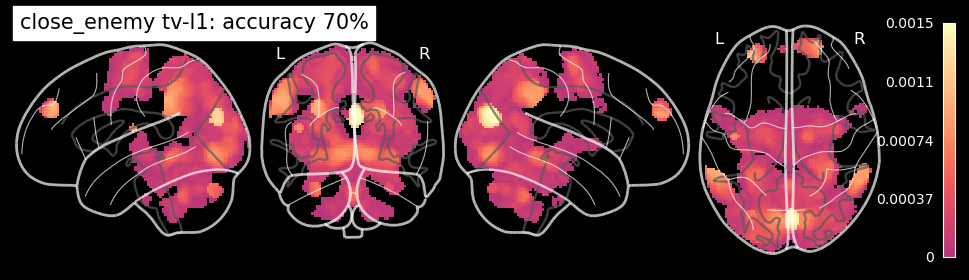

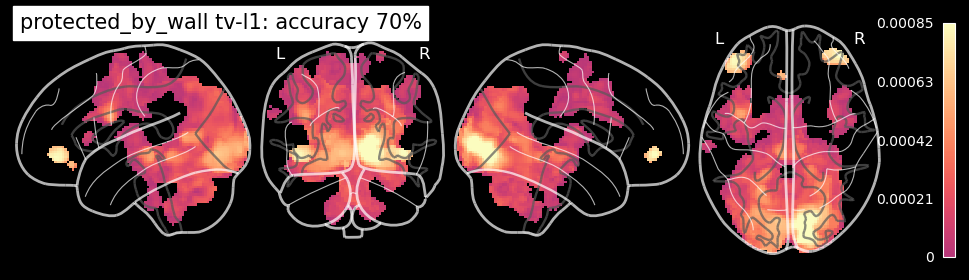

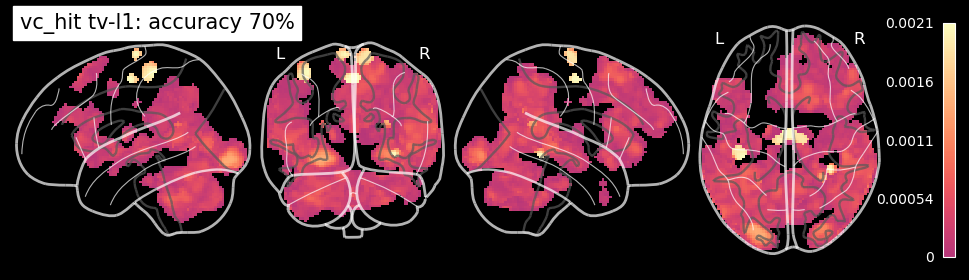

In [15]:
coef_img = decoder.coef_img_

conditions = ['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit']
for i, condition in enumerate(conditions):
    plot_glass_brain(coef_img.slicer[...,i], black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title=condition + ' tv-l1: accuracy %g%%' % accuracy)

In [18]:
print("doneee")

doneee
